In [1]:
#| code-fold: false
# IMPORTING LIBRARIES
# --------------------

# AstroML
from astroML.datasets import fetch_LINEAR_sample
from astropy.coordinates import SkyCoord
import astropy.units as u

# Basic libraries
import pickle
import os
import sys
from tqdm import tqdm

# Plotting
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import ticker
import matplotlib.colors as mcolors
from matplotlib.font_manager import FontProperties

# DataFrame analysis
import pandas as pd

# Math libraries
import numpy as np
import scipy as sc
from scipy.stats import norm

# CONFIGURATION
# -------------
sns.set_theme() # setting the theme for plotting
sys.path.insert(0,'../src/')
np.random.seed(42)

# configuring plotting colors
colors = ['#5F6372', '#79A8A4', '#B2AD8F', '#92A186', '#AD8082']
blue = '#5F6372'
turqoise = '#79A8A4'
light_green = '#B2AD8F'
green = '#92A186'
pink = '#AD8082'
muted_colors = sns.set_palette(sns.color_palette(colors))

# configuring fonts for plotting
font = FontProperties()
font.set_family('avenir')
font.set_name('Big Caslon')
font.set_style('normal')
font.set_size('xx-large')


%matplotlib inline  

In [2]:
sys.path.insert(0,'../src/')
import blazhko_analysis
import BE_plotting
import helper
import RR_lyrae_params
import data_access

In [3]:
from scipy import signal
import pywt

In [4]:
%load_ext autoreload
%autoreload 2

---

In [5]:
#| code-fold: false
# DATA from previous notebook
end = 'FINAL_FINAL_FULL'
lc_analysis = pd.read_csv('../outputs/LC_ANALYSIS_FINALFINAL_FINAL_FULL.csv')

lc_analysis['MainPeakL'] = pd.to_numeric(lc_analysis['MainPeakL'], errors='coerce').fillna(0)
lc_analysis['BlazhkoPeakL'] = pd.to_numeric(lc_analysis['BlazhkoPeakL'], errors='coerce').fillna(0)
lc_analysis['BlazhkoPeriodL'] = pd.to_numeric(lc_analysis['BlazhkoPeriodL'], errors='coerce').fillna(0)
lc_analysis['BpowerRatioL'] = pd.to_numeric(lc_analysis['BpowerRatioL'], errors='coerce').fillna(0)
lc_analysis['BsignificanceL'] = pd.to_numeric(lc_analysis['BsignificanceL'], errors='coerce').fillna(0)
lc_analysis['MainPeakZ'] = pd.to_numeric(lc_analysis['MainPeakZ'], errors='coerce').fillna(0)
lc_analysis['BlazhkoPeakZ'] = pd.to_numeric(lc_analysis['BlazhkoPeakZ'], errors='coerce').fillna(0)
lc_analysis['BlazhkoPeriodZ'] = pd.to_numeric(lc_analysis['BlazhkoPeriodZ'], errors='coerce').fillna(0)
lc_analysis['BpowerRatioZ'] = pd.to_numeric(lc_analysis['BpowerRatioZ'], errors='coerce').fillna(0)
lc_analysis['BsignificanceZ'] = pd.to_numeric(lc_analysis['BsignificanceZ'], errors='coerce').fillna(0)

lc_analysis['Pratio'] = round(lc_analysis['Pratio'], 4)
lc_analysis['Plinear'] = round(lc_analysis['Plinear'], 6)
lc_analysis['Pztf'] = round(lc_analysis['Pztf'], 6)
lc_analysis['Lampl'] = round(lc_analysis['Lampl'], 2)
lc_analysis['Zampl'] = round(lc_analysis['Zampl'], 2)
lc_analysis['L_chi2dofR'] = round(lc_analysis['L_chi2dofR'], 1)
lc_analysis['Lmean_chi2dofR'] = round(lc_analysis['Lmean_chi2dofR'], 1)
lc_analysis['Zchi2dofR'] = round(lc_analysis['Zchi2dofR'], 1)
lc_analysis['Zmean_chi2dofR'] = round(lc_analysis['Zmean_chi2dofR'], 1)
lc_analysis['L_chi2dof'] = round(lc_analysis['L_chi2dof'], 1)
lc_analysis['Lmean_chi2dof'] = round(lc_analysis['Lmean_chi2dof'], 1)
lc_analysis['Zchi2dof'] = round(lc_analysis['Zchi2dof'], 1)
lc_analysis['Zmean_chi2dof'] = round(lc_analysis['Zmean_chi2dof'], 1)
lc_analysis['Ampl_diff'] = round(abs(lc_analysis['Lampl'] - lc_analysis['Zampl']), 2)
lc_analysis['dP'] = round(abs((lc_analysis['Plinear']-lc_analysis['Pztf'])/lc_analysis['Pmean']),5)
lc_analysis['MainPeakL'] = round(lc_analysis['MainPeakL'], 4)
lc_analysis['BlazhkoPeakL'] =round(lc_analysis['BlazhkoPeakL'], 4)
lc_analysis['BlazhkoPeriodL'] = round(lc_analysis['BlazhkoPeriodL'], 4)
lc_analysis['BpowerRatioL'] = round(lc_analysis['BpowerRatioL'], 4)
lc_analysis['BsignificanceL'] = round(lc_analysis['BsignificanceL'], 4)
lc_analysis['MainPeakZ'] = round(lc_analysis['MainPeakZ'], 4)
lc_analysis['BlazhkoPeakZ'] = round(lc_analysis['BlazhkoPeakZ'], 4)
lc_analysis['BlazhkoPeriodZ'] = round(lc_analysis['BlazhkoPeriodZ'], 4)
lc_analysis['BpowerRatioZ'] = round(lc_analysis['BpowerRatioZ'], 4)
lc_analysis['BsignificanceZ'] = round(lc_analysis['BsignificanceZ'], 4)
lc_analysis['IndicatorType'] = 'NaN'
lc_analysis['ChiType'] = 'NaN'
lc_analysis['BE_score'] = 'NaN'

periodogr = pickle.load(open("../outputs/periodograms_"+end+".pkl", "rb"))
fits = np.load("../outputs/fits_"+end+".npy", allow_pickle=True)
ztf_data = np.load("../outputs/ztf_data_filter"+end+".npy", allow_pickle=True)

In [6]:
lc_analysis.head()

,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,L_rms,L_chi2dof,L_chi2dofR,Lmean_rms,...,BlazhkoPeakZ,BlazhkoPeriodZ,BpowerRatioZ,BsignificanceZ,LC_type,Ampl_diff,dP,IndicatorType,ChiType,BE_score
0,29848,0.557020,0.557035,0.5570,1.0,301,0.000000,0.0,0.0,0.000000,...,0.0000,0.0000,0.0000,0.0000,1,0.00,0.00003,NaN,NaN,NaN
1,50402,0.643303,0.643294,0.6433,1.0,284,0.105976,0.6,0.7,0.107611,...,1.9161,303.4901,0.0146,2.0748,1,0.10,0.00001,NaN,NaN,NaN
2,62892,0.530776,0.530786,0.5308,1.0,276,0.108535,1.1,0.9,0.131104,...,1.0256,42.9553,0.0618,4.7729,1,0.20,0.00002,NaN,NaN,NaN
3,91437,0.674733,0.674737,0.6747,1.0,177,0.040739,2.8,1.3,0.073285,...,1.5410,16.9635,0.0328,5.4267,1,0.16,0.00001,NaN,NaN,NaN
4,95250,0.313870,0.313877,0.3139,1.0,222,0.162522,0.8,0.8,0.865595,...,1.0929,32.3729,0.0969,8.2018,2,0.10,0.00002,NaN,NaN,NaN


95250


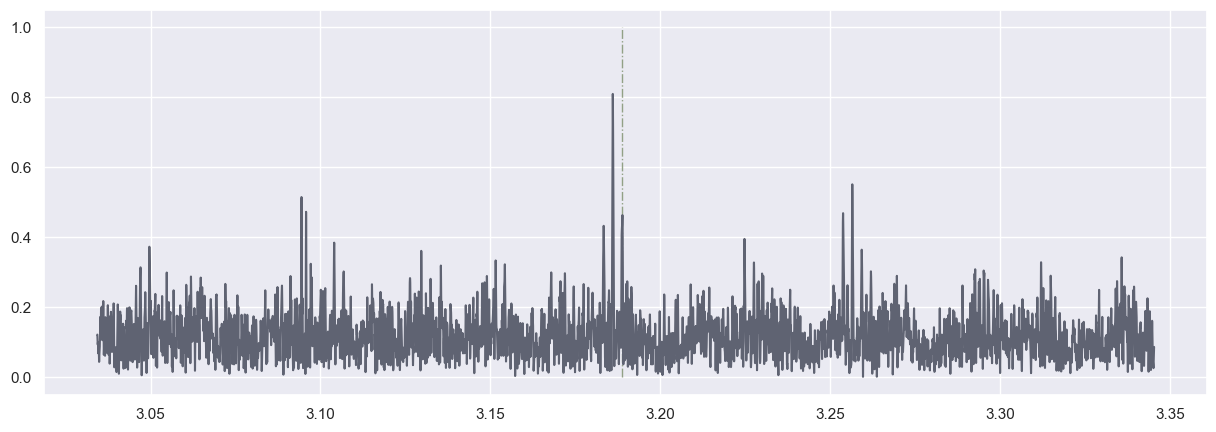

In [79]:
plt.figure(figsize=(15,5))
print(periodogr[4][0])
fl = periodogr[4][1][0]
pl = periodogr[4][1][1]
imax = np.argmax(pl)
f1yr = fl[imax] + 1.02/365
plt.plot([f1yr, f1yr], [0,1], lw = 1, ls='-.', c=green)
#plt.plot([f1yr, f1yr], [0,1], lw = 1, ls='-.', c=green)
plt.plot(fl, pl)
plt.show()

In [80]:
from scipy.stats import hmean

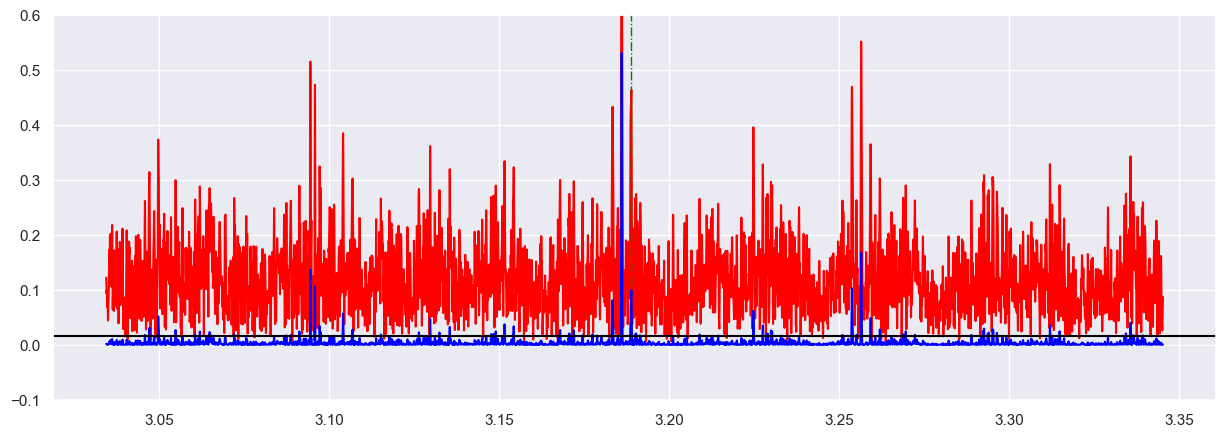

In [81]:
p2 = pl**3
plt.figure(figsize=(15,5))
plt.plot(fl, pl, c='red')
plt.plot([f1yr, f1yr], [0,1], lw = 1, ls='-.', c='green')
avg1 = np.sqrt(np.mean(p2**2))
plt.plot(fl, p2, c='blue')
plt.axhline(y = avg1, color = 'black', linestyle = '-') 
plt.ylim([-0.1,0.6])
plt.show()

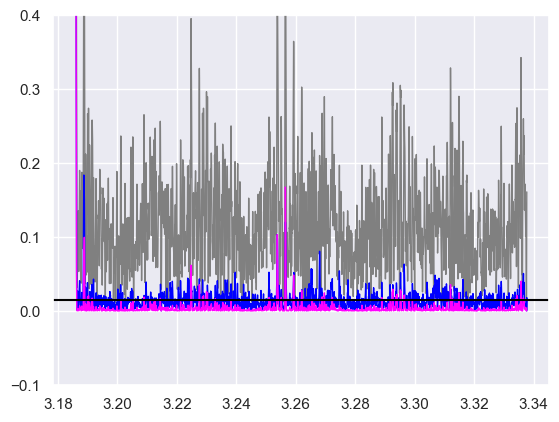

In [82]:
Npts = np.size(pl)
# index for the main peak
imax = np.argmax(pl)
# 1 year alias frequency (factor 1.02 to push it a bit over the maximum)
f1yr = fl[imax] + 1.02/365
# iDelta is the max. width for folding around the main peak
if (imax < Npts/2):
    iDelta = imax
else:
    iDelta = Npts - imax
# folded versions 
fFolded = fl[imax:imax+1+iDelta]  
pLeft = pl[imax-iDelta:imax+1]  
pRight = pl[imax:imax+1+iDelta]
pFolded = 0*fFolded
for i in range(0, iDelta-1):
    # multiply the two branches to increase SNR 
    pFolded[i] = pLeft[-i-1] * pRight[i] 
plt.plot(fFolded,pRight,c='gray',lw=1)
plt.plot(fFolded, pFolded,c='blue',lw=1)
plt.plot(fFolded,pRight**3,c='magenta',lw=1)
plt.ylim([-0.1,0.4])
avg1 = np.sqrt(np.mean(p2**2))
plt.axhline(y = avg1, color = 'black', linestyle = '-') 
plt.show()

0.01607237253567244
3.186028957821676


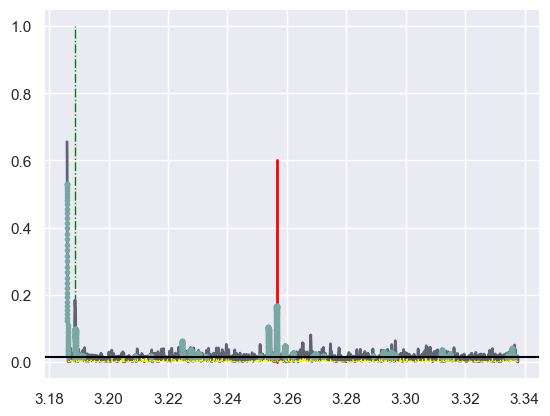

In [126]:
foundMin = 0
foldedMax = 0 
ifoldedMax = 0
# NB: the first point is the highest by construction (the main peak)
for i in range(1, iDelta):
    if ((foundMin==0)&(pFolded[i] > pFolded[i-1])):
        # the first time we passed through a local minimum
        if (fFolded[i]>f1yr): foundMin = 1
    if foundMin:
        # after the first local minimum, remember the maximum power and its location
        if (pFolded[i] > foldedMax):
            foldedMax = pFolded[i]
            ifoldedMax = i
# done, return useful quantities       
fMainPeak = fl[imax] # location of the main peak
fBlazhkoPeak = fFolded[ifoldedMax] # location of the second strongest peak

pfoldede = pRight**3
avg1 = np.sqrt(np.mean(pfoldede**2))
print(avg1)

pairs = []
for i in range(len(fFolded)):
    pairs.append((fFolded[i], pfoldede[i]))

peaks_y = [x for x in pfoldede if x>avg1]

peaks_x = []
for j in peaks_y:
    for k in pairs:
        if j==k[1]:
            peaks_x.append(k[0])

# removing the maximum

imax_1 = np.argmax(peaks_y)
peaks_x = peaks_x.remove(imax_1)
peaks_y = peaks_y.remove(max(peaks_y))

# removing the one year alias
peaks_x = peaks_x.remove(f1yr)

plt.plot([fBlazhkoPeak,fBlazhkoPeak],[0,0.6],'red',lw=2)
plt.plot([f1yr, f1yr], [0,1], lw = 1, ls='-.', c='green')
plt.plot(fFolded,pFolded,lw=2)
plt.plot(fFolded,pfoldede,c='yellow',lw=0.5)
plt.plot(peaks_x,peaks_y,'.')

plt.axhline(y = avg1, color = 'black', linestyle = '-') 
plt.show()